# Training a neural network with McSnow autoconversion output

This script applies a DNN to the regression problem to find Phi_au(tau) of Seifert and Beheng (2001)

Here it is tested with a Log transform of data and predictors is helpful. In short: it is!

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [3]:
import numpy as np
import xarray as xr

In [4]:
# mdir='/Users/axel/DWD/GITLAB/mcsnow/'
# edir='experiments/'
mdir = '../data/'
edir = '/'

# big dataset with large parameter range, e.g. starting at 9 mu radius and nu in [0,4], and 5 independent realizations
fname1=mdir+edir+'autocon_train_big.nc'
fname2=mdir+edir+'autocon_test_big.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [5]:
def read_and_prepare_data(fname,auto_sml):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    auto = xr.open_dataset(fname).auto_mass.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    nu   = xr.open_dataset(fname).nu.values
    # some numerical lower bounds
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    auto_min = 1e-15
    # introduce small but non-zero value for autoconversion into the dataset
    # (this can maybe called "data augmentation", because in that way we keep more data by adding artificial "labels")
    if auto_sml > 0:
        if (auto_sml < 1):
            # small but constant value
            auto = np.where( (Lc > 1e-5) & (auto < auto_sml) & (tau < 0.1),auto_sml,auto)
        else:
            # use autoconversion based on Long kernel. This gives our augmented data the proper scaling
            kcc = 9.44e9     # Long kernel in m3 kg-2 s-1 
            xstar = 2.6e-10    # xstar in kg
            auLg = kcc/(20*xstar) * (nu+2.0)*(nu+4.0)/(nu+1.0)**2 * Lc**2 * (Lc/(Nc+N_min))**2
            auto = np.where( (Lc > 1e-5) & (auto < auLg) & (tau < 0.1),auLg,auto)
    # take out L**2 dependency
    autoL2 = auto * np.power(Lc,-2)
    # transform everything except nu in log space
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau  = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    auto = np.log(auto, where=auto>auto_min, out=np.nan*auto)
    autoL2 = np.log(autoL2, where=autoL2>auto_min, out=np.nan*autoL2)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ auto.ravel(), autoL2.ravel(), Lc.ravel(), Xc.ravel(), Lr.ravel(), tau.ravel(), nu.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['auto','autoL2','Lc','Xc','Lr','tau','nu'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [6]:
# introduce small but non-zero value for autoconversion if AUsml > 0, Long-Value for AUsml=1#
#AUsml=1e-10
AUsml=0

dataset_train = read_and_prepare_data(fname1,AUsml)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


In [9]:
dataset_train.head()

auto     autoL2       Lc         Xc         Lr        tau   nu
124 -33.946274 -16.901932 -8.52217 -26.494270 -30.329424 -21.807255  0.0
126 -33.679760 -16.635418 -8.52217 -26.493734 -29.784315 -21.262146  0.0
135 -31.890795 -14.846454 -8.52217 -26.492180 -28.466280 -19.944109  0.0
138 -34.406319 -17.361979 -8.52217 -26.491583 -28.379604 -19.857435  0.0
141 -34.385334 -17.340994 -8.52217 -26.491323 -28.282745 -19.760576  0.0

In [6]:
dataset_test = read_and_prepare_data(fname2,0)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


### Inspect the data

In [7]:
dataset_train.head()

auto     autoL2       Lc         Xc         Lr        tau   nu
124 -33.946274 -16.901932 -8.52217 -26.494270 -30.329424 -21.807255  0.0
126 -33.679760 -16.635418 -8.52217 -26.493734 -29.784315 -21.262146  0.0
135 -31.890795 -14.846454 -8.52217 -26.492180 -28.466280 -19.944109  0.0
138 -34.406319 -17.361979 -8.52217 -26.491583 -28.379604 -19.857435  0.0
141 -34.385334 -17.340994 -8.52217 -26.491323 -28.282745 -19.760576  0.0

In [8]:
dataset_test.head()

auto     autoL2       Lc         Xc         Lr        tau   nu
59 -31.143946 -14.910666 -8.11664 -26.497606 -28.147850 -20.031210  0.0
72 -32.352753 -16.119471 -8.11664 -26.494064 -27.674234 -19.557594  0.0
78 -33.305218 -17.071939 -8.11664 -26.492352 -27.543779 -19.427139  0.0
89 -32.978275 -16.744995 -8.11664 -26.489841 -27.249037 -19.132397  0.0
90 -30.181580 -13.948299 -8.11664 -26.489706 -26.490688 -18.374048  0.0

In [9]:
dataset_train.describe()

auto         autoL2             Lc             Xc  \
count  245735.000000  245735.000000  245735.000000  245735.000000   
mean      -23.675745      -7.209690      -8.229649     -25.800087   
std         4.339726       4.355611       1.067788       0.512630   
min       -34.538685     -22.092253     -15.303329     -28.842930   
25%       -26.573981      -9.880573      -8.581377     -26.162795   
50%       -23.041180      -6.248799      -8.290715     -25.841396   
75%       -20.304625      -3.843371      -7.426123     -25.364221   
max       -13.795737       3.787673      -6.215683     -24.881920   

                  Lr            tau             nu  
count  245735.000000  245735.000000  245735.000000  
mean      -13.084309      -5.335099       2.055678  
std         5.116529       5.055968       1.387250  
min       -31.498377     -25.195736       0.000000  
25%       -16.094716      -8.252260       1.000000  
50%       -11.822026      -3.963244       2.000000  
75%        -8.928807      -1.027458       3.000000  
max        -6.217121      -0.001001       4.000000

In [10]:
dataset_test.describe()

auto         autoL2             Lc             Xc  \
count  160306.000000  160306.000000  160306.000000  160306.000000   
mean      -22.740320      -6.566473      -8.087338     -25.688189   
std         4.126917       4.243176       1.102198       0.468681   
min       -34.538486     -21.531418     -15.012845     -28.816484   
25%       -25.244240      -8.745747      -8.316905     -26.104319   
50%       -21.960708      -5.454899      -8.112919     -25.648734   
75%       -19.579383      -3.428139      -7.296438     -25.340405   
max       -14.251979       4.713244      -6.503397     -24.882051   

                  Lr            tau             nu  
count  160306.000000  160306.000000  160306.000000  
mean      -12.700498      -5.179935       2.089635  
std         5.225599       5.188109       1.388080  
min       -31.512869     -25.009264       0.000000  
25%       -15.613055      -8.038283       1.000000  
50%       -11.207225      -3.624880       2.000000  
75%        -8.433525      -0.775937       3.000000  
max        -6.504666      -0.001008       4.000000

### Further reduce data to relevant parameter range for autoconversion

In [11]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.85) ].index
    dataset.drop(idx,inplace=True)
    idx = dataset[ dataset['Lc'] < np.log(0.02e-3) ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [12]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)

In [13]:
dataset_train.describe()

auto         autoL2             Lc             Xc  \
count  223027.000000  223027.000000  223027.000000  223027.000000   
mean      -23.550781      -7.533072      -8.006578     -25.781116   
std         4.443658       4.366485       0.770020       0.495179   
min       -34.538685     -22.092253     -10.417499     -26.839777   
25%       -26.517113     -10.317708      -8.526572     -26.151456   
50%       -22.771093      -6.597451      -7.930257     -25.837381   
75%       -20.083704      -4.096217      -7.420700     -25.358384   
max       -13.795737       1.715824      -6.215683     -24.881920   

                  Lr            tau             nu  
count  223027.000000  223027.000000  223027.000000  
mean      -13.659960      -5.871604       2.092401  
std         5.020826       5.005292       1.380275  
min       -31.498377     -25.195736       0.000000  
25%       -16.641255      -8.776547       1.000000  
50%       -12.486954      -4.632226       2.000000  
75%        -9.579693      -1.697840       3.000000  
max        -6.378722      -0.162541       4.000000

In [14]:
dataset_test.describe()

auto         autoL2             Lc             Xc  \
count  142016.000000  142016.000000  142016.000000  142016.000000   
mean      -22.499413      -6.921535      -7.789646     -25.661379   
std         4.215286       4.291694       0.674080       0.446878   
min       -34.538486     -21.531418     -10.013443     -26.833748   
25%       -24.894702      -9.253724      -8.130722     -26.099292   
50%       -21.519048      -5.791202      -7.728833     -25.628598   
75%       -19.328397      -3.665484      -7.269506     -25.337011   
max       -14.251979       1.198847      -6.503397     -24.882051   

                  Lr            tau             nu  
count  142016.000000  142016.000000  142016.000000  
mean      -13.387098      -5.838539       2.133576  
std         5.163435       5.155847       1.379667  
min       -31.512869     -25.009264       0.000000  
25%       -16.320988      -8.756287       1.000000  
50%       -12.051563      -4.470391       2.000000  
75%        -9.152614      -1.545068       3.000000  
max        -6.666520      -0.162529       4.000000

### Pairplot

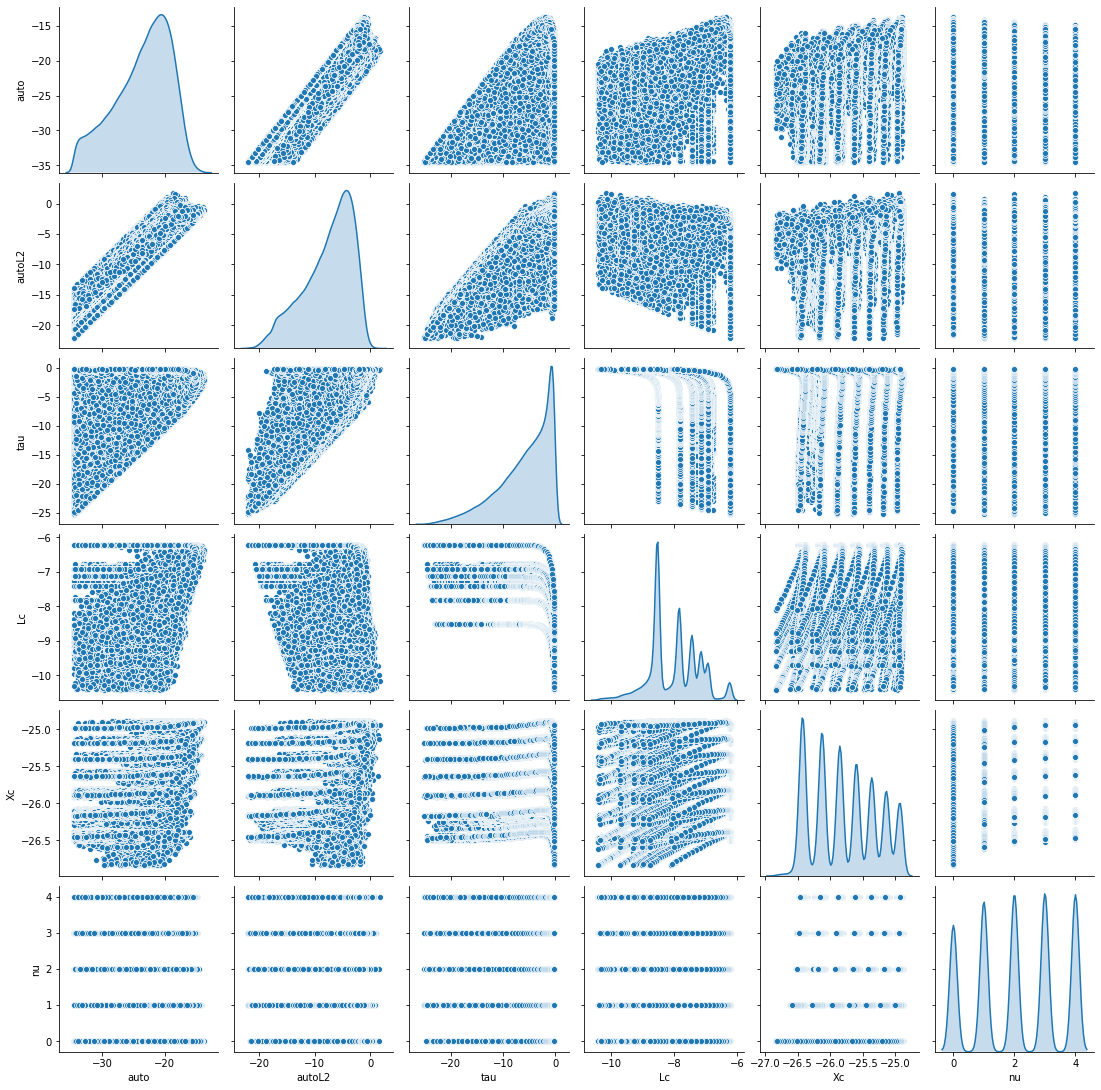

In [15]:
sns.pairplot(dataset_train[["auto","autoL2","tau","Lc","Xc",'nu']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [16]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

In [17]:
test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

In [18]:
train_dataset0 = train_dataset0.drop(['autoL2','Lr','tau','nu'], axis=1)
train_dataset1 = train_dataset1.drop(['autoL2','Lr','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['autoL2','tau'], axis=1)
train_dataset3 = train_dataset3.drop(['autoL2','Lr'], axis=1)
train_dataset4 = train_dataset4.drop(['auto','Lc','Lr'], axis=1)

In [19]:
test_dataset0 = test_dataset0.drop(['autoL2','Lr','tau','nu'], axis=1)
test_dataset1 = test_dataset1.drop(['autoL2','Lr','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['autoL2','tau'], axis=1)
test_dataset3 = test_dataset3.drop(['autoL2','Lr'], axis=1)
test_dataset4 = test_dataset4.drop(['auto','Lc','Lr'], axis=1)

In [20]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("auto")
train_stats0 = train_stats0.transpose()
train_stats0

count       mean       std        min        25%        50%        75%  \
Lc  223027.0  -8.006578  0.770020 -10.417499  -8.526572  -7.930257  -7.420700   
Xc  223027.0 -25.781116  0.495179 -26.839777 -26.151456 -25.837381 -25.358384   

          max  
Lc  -6.215683  
Xc -24.881920

In [21]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("auto")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  223027.0  -8.006578  0.770020 -10.417499  -8.526572  -7.930257  -7.420700   
Xc  223027.0 -25.781116  0.495179 -26.839777 -26.151456 -25.837381 -25.358384   
nu  223027.0   2.092401  1.380275   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Xc -24.881920  
nu   4.000000

In [22]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("auto")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  223027.0  -8.006578  0.770020 -10.417499  -8.526572  -7.930257  -7.420700   
Xc  223027.0 -25.781116  0.495179 -26.839777 -26.151456 -25.837381 -25.358384   
Lr  223027.0 -13.659960  5.020826 -31.498377 -16.641255 -12.486954  -9.579693   
nu  223027.0   2.092401  1.380275   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Xc -24.881920  
Lr  -6.378722  
nu   4.000000

In [23]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("auto")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%  \
Lc   223027.0  -8.006578  0.770020 -10.417499  -8.526572  -7.930257   
Xc   223027.0 -25.781116  0.495179 -26.839777 -26.151456 -25.837381   
tau  223027.0  -5.871604  5.005292 -25.195736  -8.776547  -4.632226   
nu   223027.0   2.092401  1.380275   0.000000   1.000000   2.000000   

           75%        max  
Lc   -7.420700  -6.215683  
Xc  -25.358384 -24.881920  
tau  -1.697840  -0.162541  
nu    3.000000   4.000000

In [24]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("autoL2")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%  \
Xc   223027.0 -25.781116  0.495179 -26.839777 -26.151456 -25.837381   
tau  223027.0  -5.871604  5.005292 -25.195736  -8.776547  -4.632226   
nu   223027.0   2.092401  1.380275   0.000000   1.000000   2.000000   

           75%        max  
Xc  -25.358384 -24.881920  
tau  -1.697840  -0.162541  
nu    3.000000   4.000000

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [25]:
train_labels0 = train_dataset0.pop('auto')
train_labels1 = train_dataset1.pop('auto')
train_labels2 = train_dataset2.pop('auto')
train_labels3 = train_dataset3.pop('auto')
train_labels4 = train_dataset4.pop('autoL2')

test_labels0  = test_dataset0.pop('auto')
test_labels1  = test_dataset1.pop('auto')
test_labels2  = test_dataset2.pop('auto')
test_labels3  = test_dataset3.pop('auto')
test_labels4  = test_dataset4.pop('autoL2')

### Normalize the data

In [26]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

In [27]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lc  223027.0 -0.002842  0.999976 -3.130982 -0.675299  0.099116  0.760861   
Xc  223027.0  0.008436  0.999979 -2.137934 -0.747890 -0.113625  0.853696   

         max  
Lc  2.325776  
Xc  1.815901

In [28]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean       std       min       25%       50%       75%  \
Lc  223027.0 -2.842162e-03  0.999976 -3.130982 -0.675299  0.099116  0.760861   
Xc  223027.0  8.435727e-03  0.999979 -2.137934 -0.747890 -0.113625  0.853696   
nu  223027.0  7.414913e-08  1.000823 -1.515931 -0.791438 -0.066944  0.657549   

         max  
Lc  2.325776  
Xc  1.815901  
nu  1.382043

In [29]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
Lc  223027.0 -2.842162e-03  0.999976 -3.130982 -0.675299  0.099116  0.760861   
Xc  223027.0  8.435727e-03  0.999979 -2.137934 -0.747890 -0.113625  0.853696   
Lr  223027.0 -1.644563e-05  1.000022 -3.552885 -0.593786  0.233628  0.812668   
nu  223027.0  7.414913e-08  1.000823 -1.515931 -0.791438 -0.066944  0.657549   

         max  
Lc  2.325776  
Xc  1.815901  
Lr  1.450207  
nu  1.382043

In [30]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc   223027.0 -2.842162e-03  0.999976 -3.130982 -0.675299  0.099116  0.760861   
Xc   223027.0  8.435727e-03  0.999979 -2.137934 -0.747890 -0.113625  0.853696   
tau  223027.0  3.629764e-06  1.000021 -3.860740 -0.580374  0.247614  0.833870   
nu   223027.0  7.414913e-08  1.000823 -1.515931 -0.791438 -0.066944  0.657549   

          max  
Lc   2.325776  
Xc   1.815901  
tau  1.140605  
nu   1.382043

In [31]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean       std       min       25%       50%       75%  \
Xc   223027.0  8.435727e-03  0.999979 -2.137934 -0.747890 -0.113625  0.853696   
tau  223027.0  3.629764e-06  1.000021 -3.860740 -0.580374  0.247614  0.833870   
nu   223027.0  7.414913e-08  1.000823 -1.515931 -0.791438 -0.066944  0.657549   

          max  
Xc   1.815901  
tau  1.140605  
nu   1.382043

# The model

## Build the model

In [32]:

def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [33]:

#activ = "PReLU"
#activ = "LReLU"
activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(3,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [35]:
example_batch  = normed_train_data4[:10]
example_result = model.predict(example_batch)
example_result

array([[0.46846652],
       [0.472038  ],
       [0.4805963 ],
       [0.48106527],
       [0.481668  ],
       [0.48263937],
       [0.48282236],
       [0.48326766],
       [0.48376697],
       [0.48863992]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [36]:
# maximum number, but we use early stopping
EPOCHS = 100

# part of training data that is used for validation during training
VALSPLIT = 0.3

# learning rate
learn = 1e-3        # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [37]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:44.7417,  mae:4.7974,  mse:44.7418,  val_loss:15.1201,  val_mae:3.1035,  val_mse:15.1201,  
.............................................

Text(0, 0.5, 'MAE')

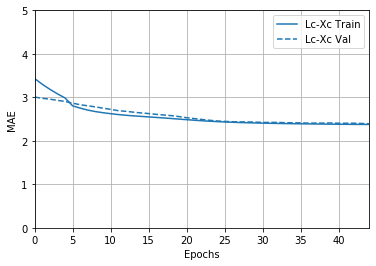

In [38]:
histories['Lc-Xc'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [39]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:52.7200,  mae:5.0836,  mse:52.7199,  val_loss:13.6526,  val_mae:2.9245,  val_mse:13.6526,  
.........................................................................................

Text(0, 0.5, 'MAE')

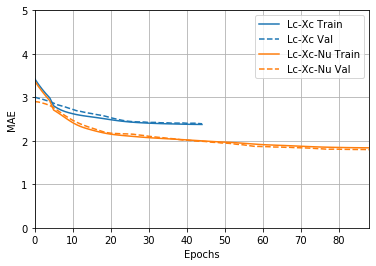

In [40]:
histories['Lc-xc-nu'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [41]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:42.8929,  mae:4.2098,  mse:42.8928,  val_loss:3.1924,  val_mae:1.2967,  val_mse:3.1924,  
..............................

In [42]:
histories['Lc-xc-nu-Lr'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [43]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:47.9932,  mae:4.5272,  mse:47.9932,  val_loss:3.1666,  val_mae:1.2725,  val_mse:3.1666,  
...........................

Text(0, 0.5, 'MAE')

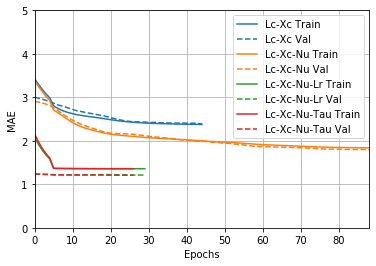

In [44]:
histories['Lc-xc-nu-tau'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [45]:
model4 = build_model(len(normed_train_data4.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data4, train_labels4, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:6.2319,  mae:1.7290,  mse:6.2319,  val_loss:3.4277,  val_mae:1.3301,  val_mse:3.4277,  
.............

In [47]:
histories['xc-nu-tau'] = early_history4

#plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
#plotter.plot(histories, metric = "mae")
#plt.ylim([0, 5])
#plt.ylabel('MAE of AU')

In [48]:
#plotter.plot(histories, metric = "mse")
#plt.ylim([0, 5])
#plt.ylabel('MSE of AU')

In [49]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

142016/142016 - 3s - loss: 21.2563 - mae: 3.2672 - mse: 21.2563
Testing set for model 0, Mean Abs Error:    3.26724


In [50]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

142016/142016 - 3s - loss: 17.3393 - mae: 2.8812 - mse: 17.3393
Testing set for model 1, Mean Abs Error:    2.88123


In [51]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

142016/142016 - 3s - loss: 2.4157 - mae: 1.0929 - mse: 2.4157
Testing set for model 2, Mean Abs Error:    1.09286


In [52]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

142016/142016 - 3s - loss: 2.4210 - mae: 1.0979 - mse: 2.4210
Testing set for model 3, Mean Abs Error:    1.09793


In [53]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data4, test_labels4, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:10.5f}".format(mae4))

142016/142016 - 3s - loss: 2.7813 - mae: 1.2447 - mse: 2.7813
Testing set for model 4, Mean Abs Error:    1.24468


Note that model4 with 'xc-nu-tau' uses a different target dataset, different labels: auto/Lc**2. Hence, the metrics shown here are not comparable. This will be fixed in the next section.

# Make predictions

Finally, predict the fall velocity values using data in the testing set:

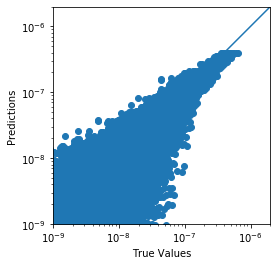

In [54]:
test_au0 = np.exp(test_labels0)
test_au1 = np.exp(test_labels1)
test_au2 = np.exp(test_labels2)
test_au3 = np.exp(test_labels3)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())
test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())

amin, amax = 1e-9, 2e-6

a = plt.axes(aspect='equal')
plt.scatter(test_au2, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [55]:
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_au3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

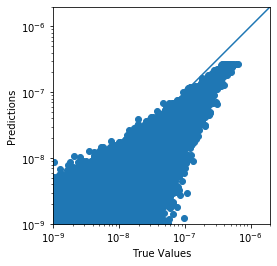

In [56]:
test_au4 = np.exp(test_labels4)

# re-scale this back to regular autoconversion
qc  = np.exp(np.array(test_dataset3.Lc))

test_predict4 = qc*qc * np.exp(model4.predict(normed_test_data4).flatten())
test_au4 = test_au4 * qc*qc

a = plt.axes(aspect='equal')
plt.scatter(test_au4, test_predict4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [57]:
test_dataset3.describe()

Lc             Xc            tau             nu
count  142016.000000  142016.000000  142016.000000  142016.000000
mean       -7.789646     -25.661379      -5.838539       2.133576
std         0.674080       0.446878       5.155847       1.379667
min       -10.013443     -26.833748     -25.009264       0.000000
25%        -8.130722     -26.099292      -8.756287       1.000000
50%        -7.728833     -25.628598      -4.470391       2.000000
75%        -7.269506     -25.337011      -1.545068       3.000000
max        -6.503397     -24.882051      -0.162529       4.000000

In [58]:
qc  = np.exp(np.array(test_dataset3.Lc))
xc  = np.exp(np.array(test_dataset3.Xc))
nue = np.array(test_dataset3.nu)

tau2 = np.exp(np.array(test_dataset3.tau))

## SB2001 autoconversion rate, original and re-trained on current data

In [59]:
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 
xstar = 2.6e-10   # xstar in kg

au = kcc/(20*xstar) * (nue+2.0)*(nue+4.0)/(nue+1.0)**2 * qc**2 * xc**2

a1 = 600.
p1 = 0.68
taup = np.power(tau2,p1)
phi1 = a1 * taup * (1.0 - taup)**3

a2 = 954.
p2 = 0.773
taup = np.power(tau2,p2)
phi2 = a2 * taup * (1.0 - taup)**3

auSB1 = au * phi1
auSB2 = au * phi2


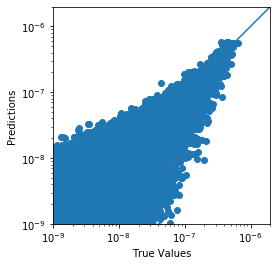

In [60]:
test_predict_sb = auSB2

amin, amax = 1e-9, 2e-6

a = plt.axes(aspect='equal')
plt.scatter(test_au3, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## KK2000 autoconversion

In [61]:

nc = qc/xc * 1e-6  # Nc in CGS

auKK = 1350. * np.power(qc,2.47) * np.power(nc,-1.79)

## Power law regression 

from notebook 'McSnow_autocon_powerlaws'

In [62]:
fac = 7.540743e+13 
a = 2.786325 
b = -1.620419 
c = -0.808443 

nc = qc/xc

# AU = fac * Lc**a * Nc**b * nu**c
auPwr = fac * np.power(qc,a) * np.power(nc,b) * np.power(nue+1,c)  

In [63]:
np.mean(auPwr)

5.856111e-09

In [64]:
np.mean(auKK)

6.1234977e-09

## Final statistics 

In [65]:
au0 = test_predict0
au1 = test_predict1
au2 = test_predict2
au3 = test_predict3
au4 = test_predict4

auTruth = test_au3

In [66]:
np.max(auTruth)

6.463149588853412e-07

In [67]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [68]:
mae0 = mean_abs_error(au0,test_au0)
mae1 = mean_abs_error(au1,test_au1)
mae2 = mean_abs_error(au2,test_au2)
mae3 = mean_abs_error(au3,test_au3)
mae4 = mean_abs_error(au4,test_au4)
maeSB1 = mean_abs_error(auSB1,auTruth)
maeSB2 = mean_abs_error(auSB2,auTruth)
maeKK  = mean_abs_error(auKK,auTruth)
maePwr = mean_abs_error(auPwr,auTruth)

mse0 = mean_sqr_error(au0,test_au0)
mse1 = mean_sqr_error(au1,test_au1)
mse2 = mean_sqr_error(au2,test_au2)
mse3 = mean_sqr_error(au3,test_au3)
mse4 = mean_sqr_error(au4,test_au4)
mseSB1 = mean_sqr_error(auSB1,auTruth)
mseSB2 = mean_sqr_error(auSB2,auTruth)
mseKK  = mean_sqr_error(auKK,auTruth)
msePwr = mean_sqr_error(auPwr,auTruth)

mae = [ mae0, mae1, mae2, mae3, mae4, maeSB1, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mse4, mseSB1, mseSB2, mseKK, msePwr ]

In [69]:
mae

[9.682945112388097e-09,
 7.444906469089574e-09,
 2.3510733360154745e-09,
 2.4483997052016093e-09,
 3.907554724236206e-09,
 3.716070340331612e-09,
 3.0527820271686323e-09,
 7.507063415346238e-09,
 6.591737822247978e-09]

In [70]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('SB new')
labels.append('KK2000')
labels.append('Power')
labels

['Lc-Xc',
 'Lc-xc-nu',
 'Lc-xc-nu-Lr',
 'Lc-xc-nu-tau',
 'xc-nu-tau',
 'SB2001',
 'SB new',
 'KK2000',
 'Power']

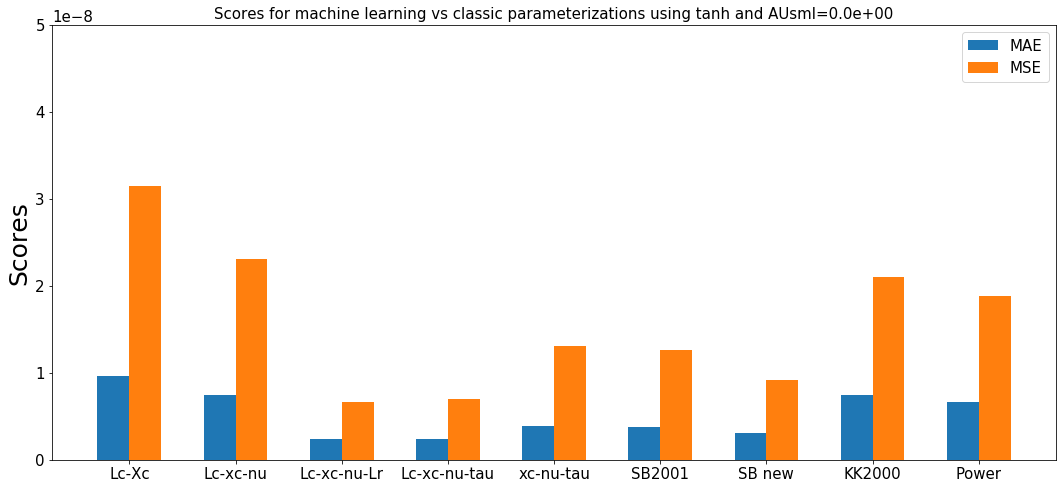

In [71]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs classic parameterizations using '+activ+' and AUsml=%6.1e'%AUsml)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,5e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Save models to file

In [72]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model

if AUsml == 1:
    AUsmlString = '_AuLong'
elif AUsml > 0:
    AUsmlString = '_AUsml%5.0e'%AUsml
else:
    AUsmlString = ''
    
model2.save('saved_model/autocon_LcXcNuLr_v5_'+activ+AUsmlString+'_16x16x16') 
model3.save('saved_model/autocon_LcXcNuTau_v5_'+activ+AUsmlString+'_16x16x16') 
model4.save('saved_model/autoL2_XcNuTau_v5_'+activ+AUsmlString+'_16x16x16') 

# save train_stats for normalization of input data in Pandas pickle format
#train_stats1.to_pickle('saved_model/autocon_LcXcNu_16x16x16_norm.pickle')
train_stats2.to_pickle('saved_model/autocon_LcXcNuLr_v5_'+activ+AUsmlString+'_16x16x16_norm.pickle')
train_stats3.to_pickle('saved_model/autocon_LcXcNuTau_v5_'+activ+AUsmlString+'_16x16x16_norm.pickle')
train_stats4.to_pickle('saved_model/autoL2_XcNuTau_v5_'+activ+AUsmlString+'_16x16x16_norm.pickle')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/autocon_LcXcNuLr_v5_tanh_16x16x16/assets
INFO:tensorflow:Assets written to: saved_model/autocon_LcXcNuTau_v5_tanh_16x16x16/assets
INFO:tensorflow:Assets written to: saved_model/autoL2_XcNuTau_v5_tanh_16x16x16/assets


# Model on gridded data to visualize dependencies

In [73]:

qc1d = np.linspace(0.1,2.0,50) * 1e-3
#tau1d = np.logspace(1e-6,1.0,51)
tau1d = np.linspace(0,1.0,50)
nu1d = np.linspace(0,4,6)
rc1d = np.linspace(11,15,10) * 1e-6
#nc1d = np.linspace(np.nanmin(Nc),np.nanmax(Nc),20)

tau1d[0] = 1e-6

qc3d, tau3d, nu3d, rc3d = np.meshgrid(qc1d, tau1d, nu1d, rc1d)

xc3d = 4./3. * 3.14 * 1e3 * rc3d**3

In [74]:
nc3d = qc3d/xc3d
qr3d = qc3d * (1.0/tau3d - 1.0)

In [75]:
gdata = pd.DataFrame(np.array( [ np.log(qc3d.ravel()), np.log(xc3d.ravel()), np.log(qr3d.ravel()), np.log(tau3d.ravel()), nu3d.ravel() ]))
gdata = gdata.T
gdata.columns = ['Lc','Xc','Lr','tau','nu'] 

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [76]:
gdata1 = gdata.copy()
gdata2 = gdata.copy()
gdata3 = gdata.copy()

In [77]:
gdata1 = gdata.drop(['Lr','tau'], axis=1)
gdata2 = gdata.drop("tau", axis=1)
gdata3 = gdata.drop("Lr", axis=1)

In [78]:
gdata3.head()

Lc         Xc        tau   nu
0 -9.21034 -25.913186 -13.815511  0.0
1 -9.21034 -25.794358 -13.815511  0.0
2 -9.21034 -25.680059 -13.815511  0.0
3 -9.21034 -25.569955 -13.815511  0.0
4 -9.21034 -25.463749 -13.815511  0.0

In [79]:
gdata3_stats = gdata3.describe()
gdata3_stats.transpose()

count       mean       std        min        25%        50%  \
Lc   150000.0  -7.070660  0.740840  -9.210340  -7.478143  -6.859136   
Xc   150000.0 -25.426613  0.296577 -25.913186 -25.680059 -25.412462   
tau  150000.0  -1.198979  2.001299 -13.815511  -1.406914  -0.693355   
nu   150000.0   2.000000  1.366265   0.000000   0.800000   2.000000   

           75%        max  
Lc   -6.479424  -6.214608  
Xc  -25.165984 -24.982721  
tau  -0.280902   0.000000  
nu    3.200000   4.000000

In [80]:
normed_gdata1 = norm(gdata1,train_stats1)
normed_gdata2 = norm(gdata2,train_stats2)
normed_gdata3 = norm(gdata3,train_stats3)

normed_gdata1_stats = normed_gdata1.describe()
normed_gdata1_stats.transpose()

count      mean       std       min       25%       50%       75%  \
Lc  150000.0  1.215447  0.962104 -1.563286  0.686261  1.490146  1.983264   
Xc  150000.0  0.715909  0.598929 -0.266710  0.204083  0.744487  1.242242   
nu  150000.0 -0.066944  0.989850 -1.515931 -0.936336 -0.066944  0.802448   

         max  
Lc  2.327172  
Xc  1.612337  
nu  1.382043

In [81]:
auto1 = model1.predict(normed_gdata1).flatten()
auto2 = model2.predict(normed_gdata2).flatten()
auto3 = model3.predict(normed_gdata3).flatten()


In [82]:
auto3d_model1 = np.exp(np.reshape(auto1,qc3d.shape))
auto3d_model2 = np.exp(np.reshape(auto2,qc3d.shape))
auto3d_model3 = np.exp(np.reshape(auto3,qc3d.shape))

In [83]:
qc3d.shape

(50, 50, 6, 10)

In [84]:
au = kcc/(20*xstar) * (nu3d+2.0)*(nu3d+4.0)/(nu3d+1.0)**2 * qc3d**2 * xc3d**2
taup = np.power(tau3d,p2)
phi2 = a2 * taup * (1.0 - taup)**3

auSB = au * phi2

In [85]:
np.nanmean(auSB)

3.7857145093017184e-08

In [86]:
np.nanmean(auto3d_model3)

8.123671e-08

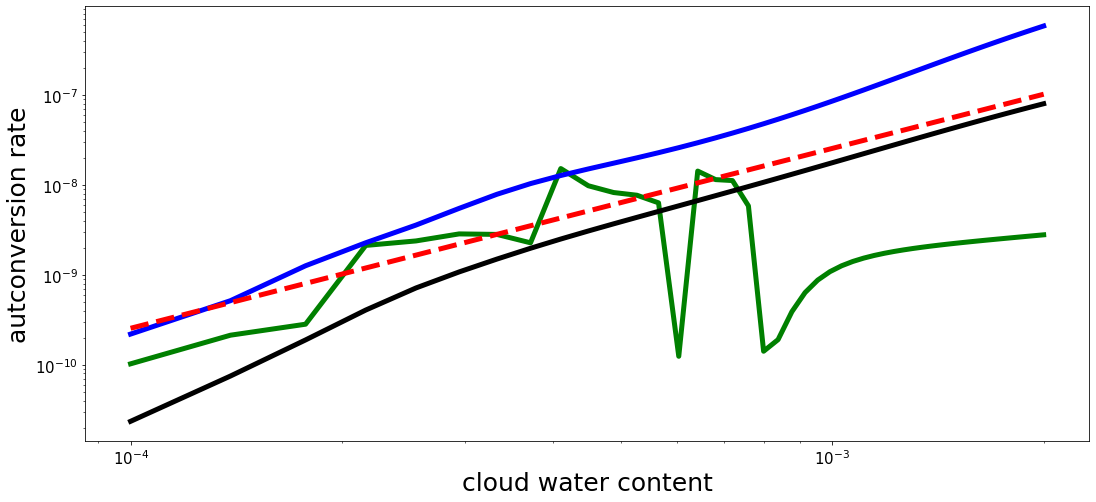

In [87]:
iqr = 3
inu = 2
inc = 3

plt.plot(qc3d[iqr,:,inu,inc], auto3d_model1[iqr,:,inu,inc], 'g-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auto3d_model2[iqr,:,inu,inc], 'b-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auto3d_model3[iqr,:,inu,inc], 'k-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auSB[iqr,:,inu,inc], 'r--', linewidth=5)

plt.xlabel('cloud water content')
plt.ylabel('autconversion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

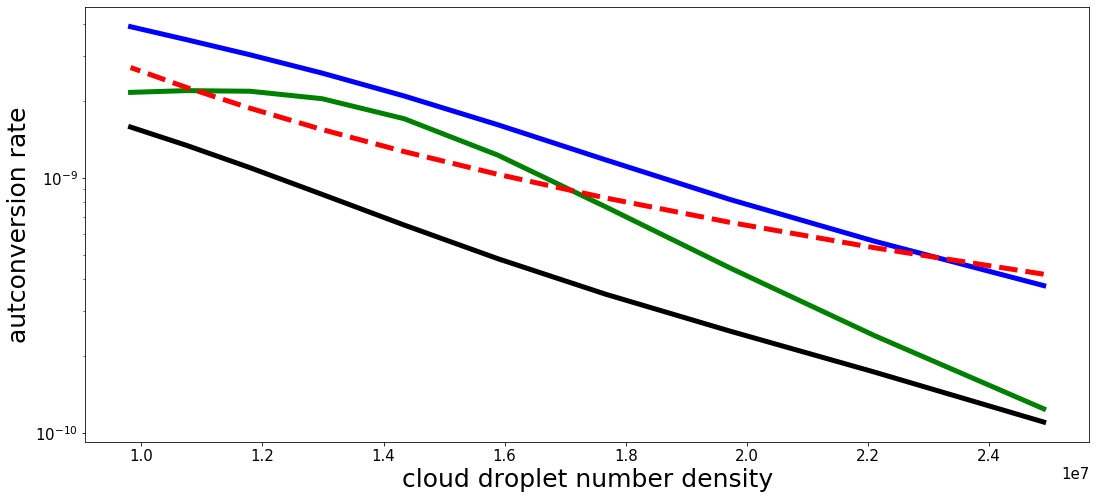

In [88]:
iqc = 1
iqr = 5
inu = 1

plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model1[iqr,iqc,inu,:], 'g-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model2[iqr,iqc,inu,:], 'b-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model3[iqr,iqc,inu,:], 'k-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auSB[iqr,iqc,inu,:], 'r--', linewidth=5)

plt.xlabel('cloud droplet number density')
plt.ylabel('autconversion rate')

plt.yscale('log')
#plt.xscale('log')
plt.show()

In [89]:
iqc = 20
inu = 2
inc = 3

#plt.plot(tau3d[:,iqc,inu,inc], auto3d_model2[:,iqc,inu,inc], 'g-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auto3d_model2[:,iqc,inu,inc], 'b-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auto3d_model3[:,iqc,inu,inc], 'k-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auSB[:,iqc,inu,inc], 'r--', linewidth=5)

plt.xlabel('liquid water time scale tau')
plt.ylabel('autconversion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

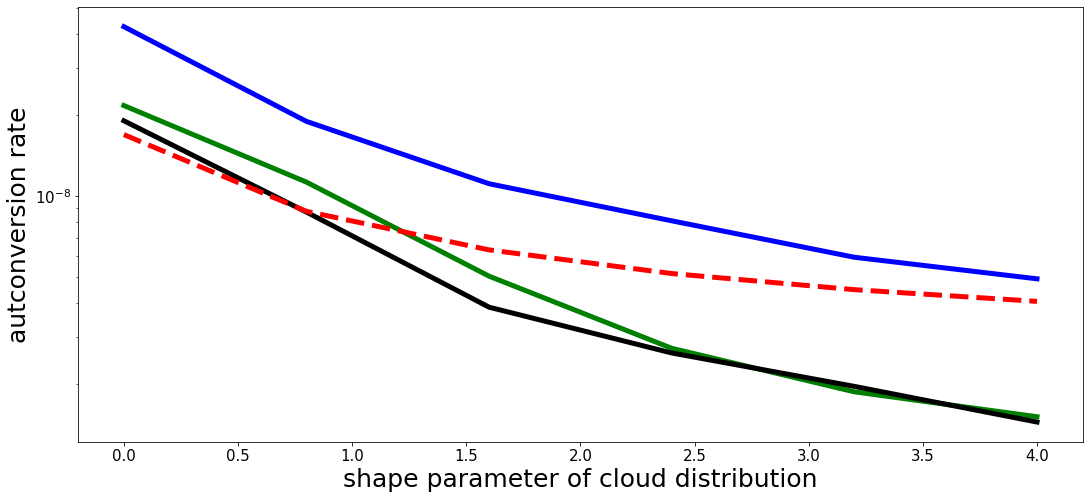

In [90]:
iqr = 10
iqc = 10
inc = 2

plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model1[iqr,iqc,:,inc], 'g-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model2[iqr,iqc,:,inc], 'b-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model3[iqr,iqc,:,inc], 'k-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auSB[iqr,iqc,:,inc], 'r--', linewidth=5)

plt.xlabel('shape parameter of cloud distribution')
plt.ylabel('autconversion rate')

plt.yscale('log')
#plt.xscale('log')
plt.show()

In [91]:
def autocon(qc,xc,qr,nu):
    tau  = qr/(qc+qr)
    data = pd.DataFrame(np.array( [ np.log(qc.ravel()), np.log(xc.ravel()), np.log(tau.ravel()), nu.ravel() ]))
    data = data.T
    data.columns = [ 'Lc','Xc','tau','nu' ] 
    normed_data = norm(data,train_stats3)
    auto = model3.predict(normed_data).flatten()

    return np.exp(auto)

In [92]:

qc = np.array(1e-3)
xc = np.array(7.2e-12)
qr = np.array(1e-10)
nu = np.array(0.0)
print(autocon(qc,xc,qr,nu))

[2.499073e-12]
